Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [69]:
from itertools import product
from random import random, randint, shuffle, seed
import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt
from tqdm import tqdm

In [70]:
def visualize_set_covering_problem(sets):
    # Convert the lil_array to np array with integer data type
    sets = np.array(sets.toarray(), dtype=int)

    plt.imshow(sets, cmap="binary", aspect="auto")
    plt.xlabel("Points")
    plt.ylabel("Sets")
    plt.title("Set Covering Problem")
    plt.show()


def make_set_covering_problem(num_points, num_sets, density):
    """Returns a sparse array where rows are sets and columns are the covered items"""
    seed(num_points * 2654435761 + num_sets + density)
    sets = sparse.lil_array((num_sets, num_points), dtype=bool)
    for s, p in product(range(num_sets), range(num_points)):
        if random() < density:
            sets[s, p] = True
    for p in range(num_points):
        sets[randint(0, num_sets - 1), p] = True

    if num_points==100:
        visualize_set_covering_problem(sets)

    return sets


# Halloween Challenge

Find the best solution with the fewest calls to the fitness functions for:

* `num_points = [100, 1_000, 5_000]`
* `num_sets = num_points`
* `density = [.3, .7]` 

In [71]:
# x = make_set_covering_problem(1000, 1000, 0.3)
# print("Element at row=42 and column=42:", x[42, 42])


# Problem Creation

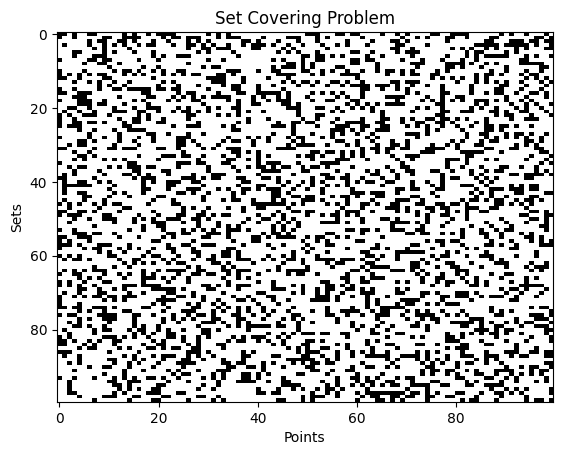

In [72]:
NUM_POINTS = [100, 1_000, 5_000]
NUM_SETS = NUM_POINTS
DENSITY = [0.3, 0.7]

DIM_INDEX=0
PROBLEM_DIM=NUM_POINTS[DIM_INDEX]

problem = make_set_covering_problem(PROBLEM_DIM, PROBLEM_DIM, DENSITY[0])


In [73]:
def check_solution(problem, sets):
    solu = [False for i in range(PROBLEM_DIM)]

    for s in sets:
        for p in range(PROBLEM_DIM):
            solu[p] = solu[p] or problem[s, p]

    return np.all(solu)


assert check_solution(problem, range(PROBLEM_DIM))


# A*

In [74]:
from collections import namedtuple
import heapq
from tqdm import tqdm

State = namedtuple("State", ["taken", "cost", "heuristic"])


def cost(state):
    return len(state.taken)


def heuristic(problem, state):
    # Count the number of uncovered elements by summing the rows of uncovered sets
    uncovered = problem[
        :, [p for p in range(PROBLEM_DIM) if p not in state.taken]
    ].sum()

    # Calculate the density
    density = uncovered.sum() / (PROBLEM_DIM - len(state.taken))

    return -density * PROBLEM_DIM


def astar(problem):
    open_list = [
        (0, State([], 0, heuristic(problem, State([], 0, 0))))
    ]  # Priority queue (f, state)
    closed_set = set()

    pbar = tqdm(total=None)

    while open_list:
        _, current_state = heapq.heappop(open_list)

        pbar.update(1)

        if check_solution(problem, current_state.taken):
            return current_state  # All points are covered

        if tuple(current_state.taken) in closed_set:
            continue

        closed_set.add(tuple(current_state.taken))

        for i in range(PROBLEM_DIM):
            if i not in current_state.taken:
                new_taken = current_state.taken + [i]
                new_cost = cost(State(new_taken, 0, 0))
                new_heuristic = heuristic(problem, State(new_taken, 0, 0))
                total_cost = new_cost + new_heuristic

                heapq.heappush(
                    open_list, (total_cost, State(new_taken, new_cost, new_heuristic))
                )

    return None  # No solution found


In [77]:
sol= astar(problem)
print(sol)
print(check_solution(problem,sol.taken))

0it [00:00, ?it/s]

13it [00:02,  5.29it/s]

State(taken=[39, 12, 8, 18, 41, 42, 75, 1, 35, 57, 73, 79], cost=12, heuristic=-3163.6363636363635)
True
